In [15]:
history_location = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Classification-2/master/data/lending-club-subset.csv'
current_location = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Classification-2/master/data/primaryMarketNotes_browseNotes_1-RETAIL.csv'

In [16]:
import pandas as pd
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

# Stratified sample, 10% of expired Lending Club loans, grades A-D
# Source: https://www.lendingclub.com/info/download-data.action
history = pd.read_csv(history_location)
history['issue_d'] = pd.to_datetime(history['issue_d'], infer_datetime_format=True)

# Current loans available for manual investing, June 17, 2019
# Source: https://www.lendingclub.com/browse/browse.action
current = pd.read_csv(current_location)

In [19]:
# Calculate percent of each loan repaid
history['percent_paid'] = history['total_pymnt'] / history['funded_amnt']

# See percent paid for charged off vs fully paid loans
history.groupby('loan_status')['percent_paid'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,22477.0,0.546541,0.278077,0.0,0.327761,0.514006,0.742090,1.490546
Fully Paid,105857.0,1.146904,0.089759,1.0,1.083836,1.132098,1.195798,1.623628


In [18]:
history.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,109889419.0,NaN,20000.0,20000.0,20000.0,36 months,9.44%,640.10,B,B1,IT Support,10+ years,MORTGAGE,99500.0,Source Verified,2017-05-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,296xx,SC,17.19,0.0,Feb-2005,690.0,694.0,0.0,NaN,NaN,15.0,0.0,12835.0,41%,28.0,w,0.0,0.0,21657.670000,21657.67,20000.0,1657.67,0.0,0.0,0.0,Jun-2018,1002.69,NaN,Jul-2018,744.0,740.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,1185.0,159516.0,2.0,3.0,0.0,2.0,16.0,59354.0,70.0,2.0,2.0,4810.0,57.0,31300.0,2.0,0.0,1.0,4.0,10634.0,15465.0,45.4,0.0,0.0,147.0,115.0,3.0,3.0,4.0,3.0,NaN,7.0,NaN,0.0,4.0,4.0,7.0,9.0,8.0,11.0,16.0,4.0,15.0,0.0,0.0,0.0,2.0,100.0,28.6,0.0,0.0,206029.0,72189.0,28300.0,84078.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68579794.0,NaN,21600.0,21600.0,21600.0,36 months,9.80%,694.95,B,B3,Engineer Tech,10+ years,MORTGAGE,79000.0,Verified,2016-01-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,219xx,MD,18.94,1.0,Jun-1995,680.0,684.0,0.0,12.0,NaN,13.0,0.0,17498.0,88.4%,16.0,w,0.0,0.0,24983.207947,24983.21,21600.0,3383.21,0.0,0.0,0.0,Nov-2018,8.94,NaN,May-2019,709.0,705.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,291267.0,0.0,2.0,2.0,2.0,7.0,33987.0,88.0,0.0,0.0,4746.0,88.0,19800.0,0.0,0.0,0.0,2.0,22405.0,897.0,91.1,0.0,0.0,101.0,247.0,27.0,7.0,4.0,27.0,12.0,NaN,12.0,0.0,3.0,7.0,4.0,4.0,4.0,8.0,8.0,7.0,13.0,0.0,0.0,0.0,2.0,93.7,75.0,0.0,0.0,337728.0,51485.0,10100.0,38591.0,NaN,N

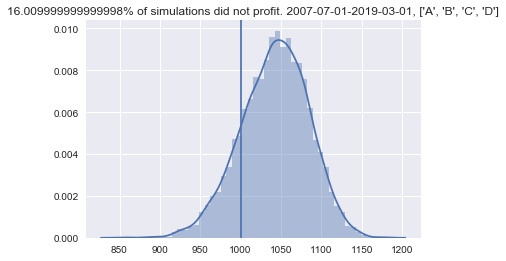

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore
import seaborn as sns
from tqdm import tnrange

def simulate(n=10000, grades=['A','B','C','D'], 
             start_date='2007-07-01', 
             end_date='2019-03-01'):
    """
    What if you picked 40 random loans for $25 investments?
    How much would you have been paid back?
    
    Repeat the simulation many times, and plot the distribution 
    of probable outcomes.
    
    This doesn't consider fees or "time value of money."
    """
    
    condition = ((history['grade'].isin(grades)) & 
                 (history['issue_d'] >= start_date) &
                 (history['issue_d'] <= end_date))
    possible = history[condition]
    
    simulations = []
    for _ in tnrange(n):
        picks = possible.sample(40).copy()
        picks['paid'] = 25 * picks['percent_paid']
        paid = picks['paid'].sum()
        simulations.append(paid)
        
    simulations = pd.Series(simulations)
    sns.distplot(simulations)
    plt.axvline(x=1000)
    percent = percentileofscore(simulations, 1000)
    plt.title(f'{percent}% of simulations did not profit. {start_date}-{end_date}, {grades}')

simulate()